# Compute rates per lpGBT link

We need to merge:
- a rates map that gives the rate per module.
- a links map that tells which module goes with which lpGBT link.

This must be done taking care of modules whose data is spread across two lpGBTs.

In [1]:
from pprint import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 144
import itertools as it
from functools import reduce
import operator as op
import numpy as np

In [2]:
import sys
(sys.version, pd.__version__, sns.__version__, plt.matplotlib.__version__, np.__version__)

('3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]',
 '1.2.4',
 '0.11.1',
 '3.3.4',
 '1.20.1')

## Read in the Module<->rate mapping
Module rates are given one per line. Let's take a peek:

In [3]:
with open('dat/rates/SectorEcondAsicTestStatsPD_2.txt') as f:
    print(f.readline())

 1  3  2  0 F      155.139      13.4736      151.878    148  5



Let's define what the columns mean with both a short form for `pandas` and a long for _humans_.

In [4]:
rates_col_description = {
    'Layer': 'Module Layer',
    'U': 'Module U',
    'V': 'Module V',
    'Type': 'Module type',
    'Shape': 'Module shape',
    'ADCHits': 'Average ADC hits [20b]',
    'TOXHits': 'Average TOX hits [30b]',
    'EvSize': 'Average event size [32b words]',
    'EvSizeXCheck': 'Average event size xcheck from average number of hits [32b words]',
    'Elinks': 'Number of ECOND elinks',
}

#Extract the column labels for the data frame (freeze it in a tuple)
rates_col_labels=tuple(rates_col_description.keys())

#Make the main description dict reversible for easy .rename() of columns back and forth
rates_col_description.update(
    {long: short for (short, long) in rates_col_description.items()}
    )

pprint(rates_col_labels)

('Layer',
 'U',
 'V',
 'Type',
 'Shape',
 'ADCHits',
 'TOXHits',
 'EvSize',
 'EvSizeXCheck',
 'Elinks')


In [5]:
rates_col_description

{'Layer': 'Module Layer',
 'U': 'Module U',
 'V': 'Module V',
 'Type': 'Module type',
 'Shape': 'Module shape',
 'ADCHits': 'Average ADC hits [20b]',
 'TOXHits': 'Average TOX hits [30b]',
 'EvSize': 'Average event size [32b words]',
 'EvSizeXCheck': 'Average event size xcheck from average number of hits [32b words]',
 'Elinks': 'Number of ECOND elinks',
 'Module Layer': 'Layer',
 'Module U': 'U',
 'Module V': 'V',
 'Module type': 'Type',
 'Module shape': 'Shape',
 'Average ADC hits [20b]': 'ADCHits',
 'Average TOX hits [30b]': 'TOXHits',
 'Average event size [32b words]': 'EvSize',
 'Average event size xcheck from average number of hits [32b words]': 'EvSizeXCheck',
 'Number of ECOND elinks': 'Elinks'}

Make human readable labels for the module types:

In [6]:
module_type = {
    0: 'HD',
    1: 'LD',
}
module_type.update(
    { i: f'Sci{i-2}' for i in range(2,12) }
)
pprint(module_type)

{0: 'HD',
 1: 'LD',
 2: 'Sci0',
 3: 'Sci1',
 4: 'Sci2',
 5: 'Sci3',
 6: 'Sci4',
 7: 'Sci5',
 8: 'Sci6',
 9: 'Sci7',
 10: 'Sci8',
 11: 'Sci9'}


In [7]:
def make_LUV(df):
     return 256*df['Layer'] + 16*df['U'] + df['V']

def make_LUV_index(df):
    df['LUV'] = make_LUV(df)
    df.set_index('LUV', inplace=True, verify_integrity=True)

Read in the module `rates` table:

In [8]:
rates = pd.read_table(
    'dat/rates/SectorEcondAsicTestStatsPD_2.txt',
    sep='\s+',
    header=None,
    names=rates_col_labels,
    converters={
        'Type': lambda x: module_type[int(x)],
        },
    dtype={
        'Layer': np.uint8,
        'Elinks': np.int16,
        'U': np.int8,
        'V': np.int8,
        }  
    )

make_LUV_index(rates)

In [9]:
rates.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4851 entries, 306 to 12795
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Layer         4851 non-null   uint8  
 1   U             4851 non-null   int8   
 2   V             4851 non-null   int8   
 3   Type          4851 non-null   object 
 4   Shape         4851 non-null   object 
 5   ADCHits       4851 non-null   float64
 6   TOXHits       4851 non-null   float64
 7   EvSize        4851 non-null   float64
 8   EvSizeXCheck  4851 non-null   int64  
 9   Elinks        4851 non-null   int16  
dtypes: float64(3), int16(1), int64(1), int8(2), object(2), uint8(1)
memory usage: 767.8 KB


In [10]:
rates

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks
LUV,,,,,,,,,,
306,1,3,2,HD,F,155.139000,13.473600,151.8780,148,5
289,1,2,1,HD,d,109.195000,13.963700,107.4950,108,3
323,1,4,3,HD,F,83.525700,5.649590,96.1745,93,3
275,1,1,3,HD,F,155.107000,13.531100,151.8990,149,5
274,1,1,2,HD,d,109.327000,13.894200,107.5330,108,3
...,...,...,...,...,...,...,...,...,...,...
12791,50,15,7,Sci9,f,0.273679,0.175417,27.4491,27,5
12792,50,15,8,Sci9,F,0.276978,0.177971,27.4549,27,5
12793,50,15,9,Sci9,F,0.274512,0.169280,27.4438,27,5


In [11]:
rates.describe(include = 'all')

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks
count,4851.000000,4851.000000,4851.000000,4851,4851,4851.000000,4851.000000,4851.000000,4851.000000,4851.000000
unique,NaN,NaN,NaN,12,17,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,LD,F,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,3799,3791,NaN,NaN,NaN,NaN,NaN
mean,24.472686,5.713049,5.145537,NaN,NaN,15.674103,2.212676,31.682696,31.643785,1.503814
std,13.352069,3.278124,3.030745,NaN,NaN,31.223396,5.005285,30.636124,30.686121,1.102077
min,1.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,9.000000,9.000000,1.000000
25%,13.000000,3.000000,3.000000,NaN,NaN,0.676720,0.226915,15.766850,16.000000,1.000000
50%,25.000000,5.000000,5.000000,NaN,NaN,3.156350,0.605055,18.994100,19.000000,1.000000
75%,35.000000,8.000000,8.000000,NaN,NaN,14.143150,2.043410,32.316600,33.000000,1.000000


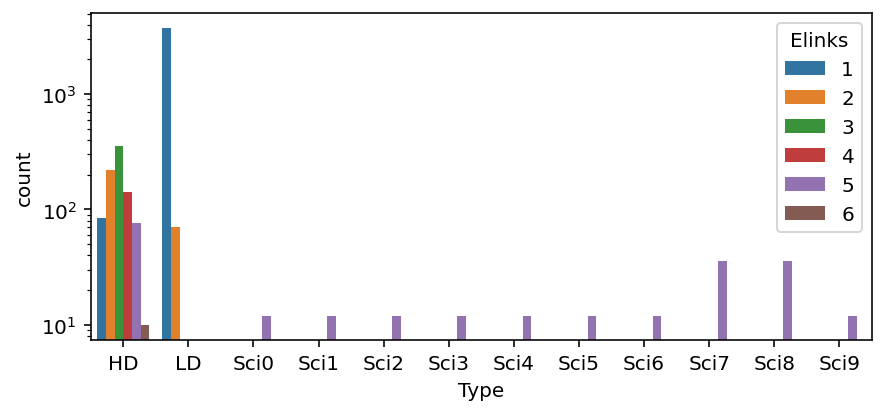

In [12]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(data=rates, x='Type', hue='Elinks').set_yscale('log')

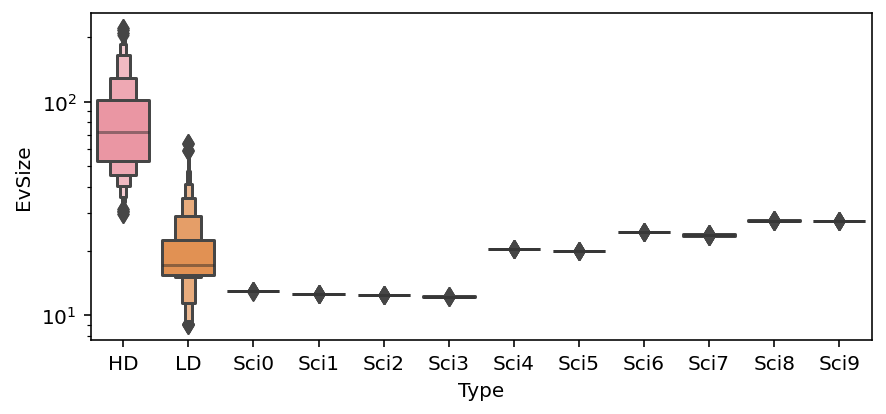

In [13]:
f, ax = plt.subplots(figsize=(7, 3))
sns.boxenplot(data=rates, x='Type', y='EvSize').set_yscale('log')

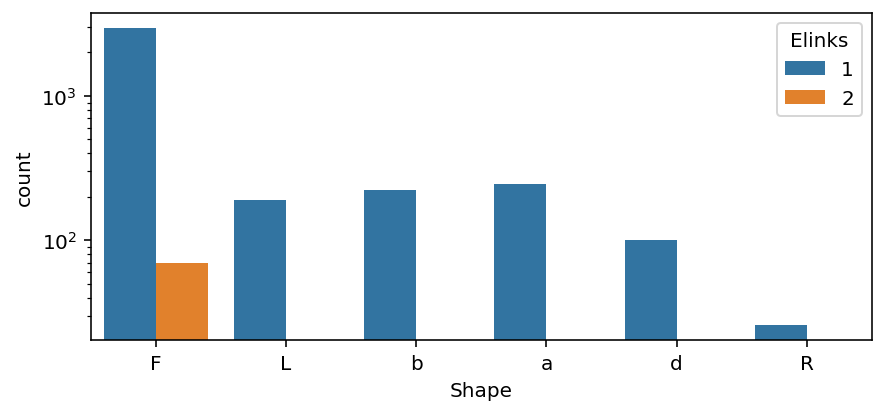

In [14]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(data=rates[ rates.Type=='LD' ], x='Shape', hue='Elinks').set_yscale('log')

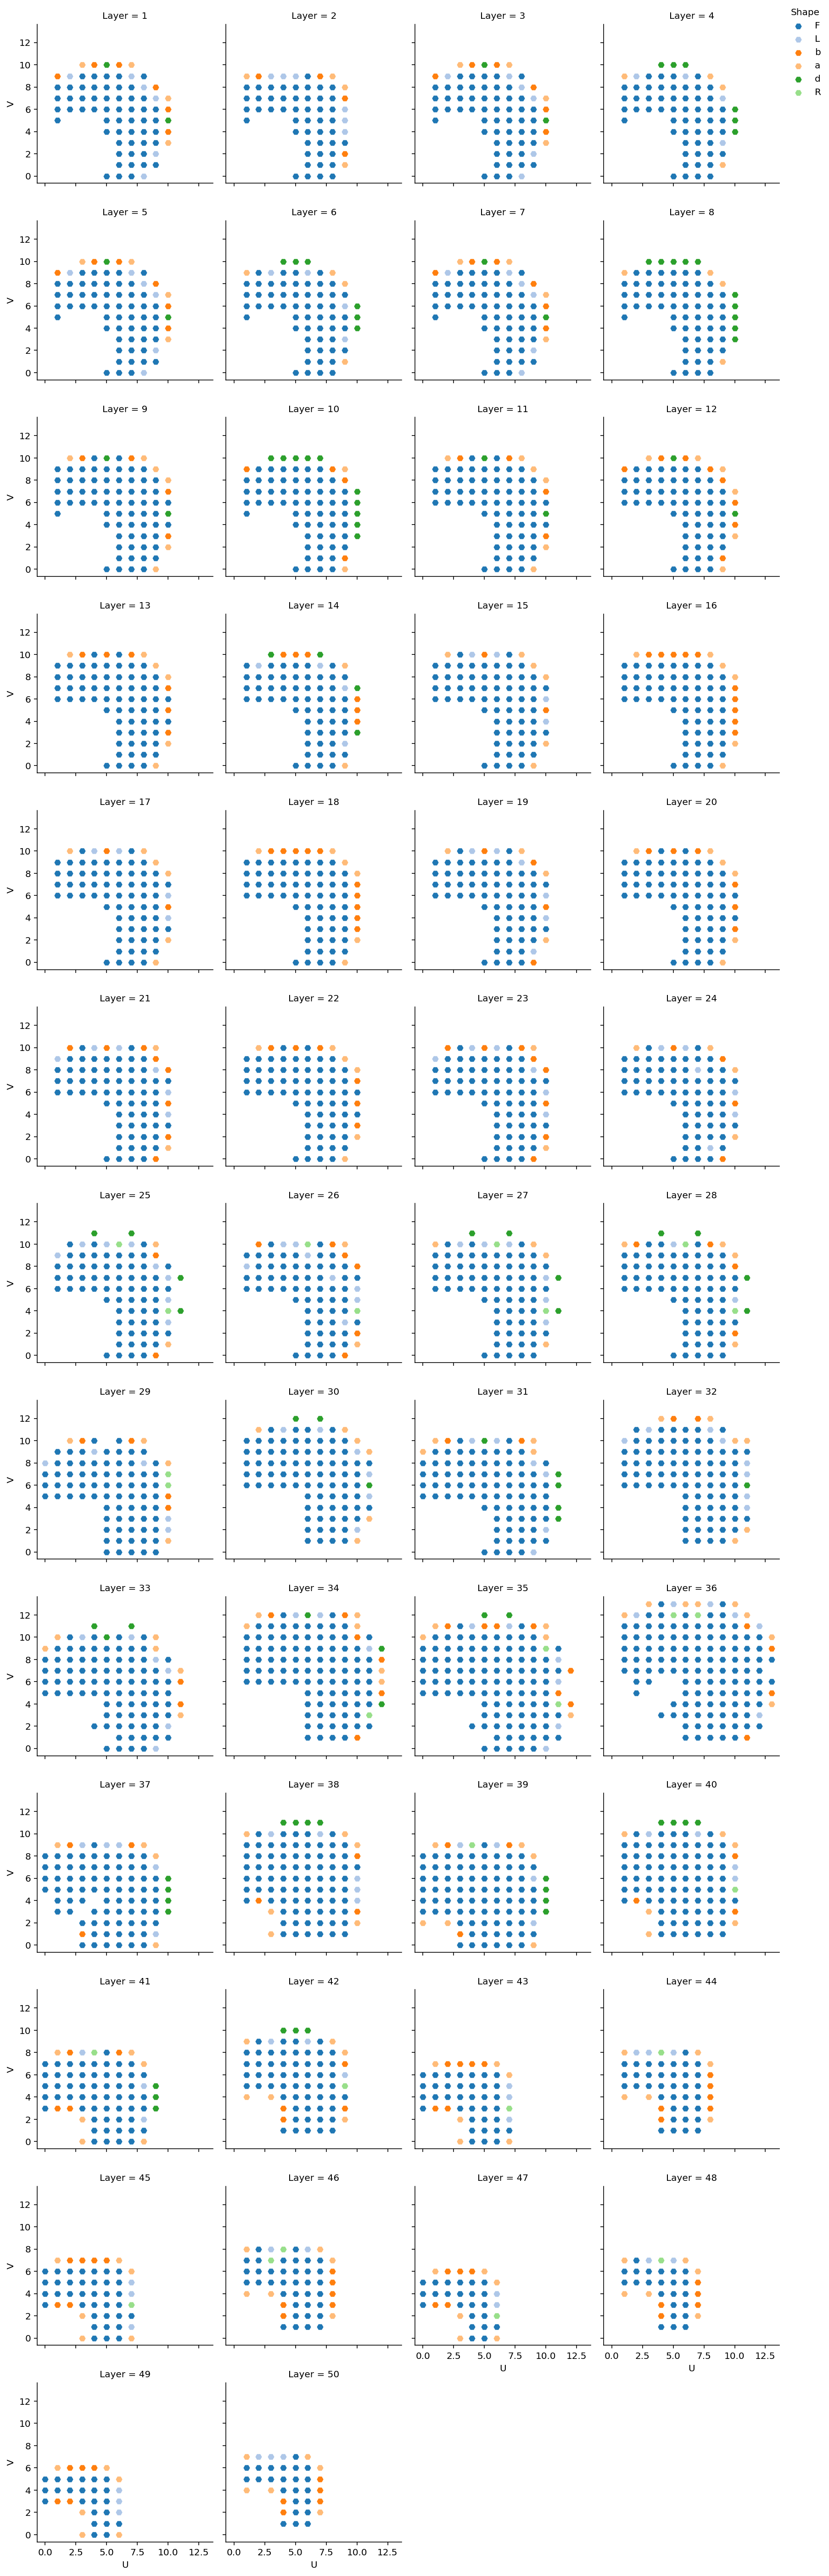

In [15]:
g = sns.FacetGrid(rates[ rates.Type=='LD' ], hue='Shape', col='Layer',
    palette='tab20',
    sharex=True, sharey=True, col_wrap=4)
g.map(plt.scatter, 'U', 'V', marker='H')
g.add_legend(loc='upper right')

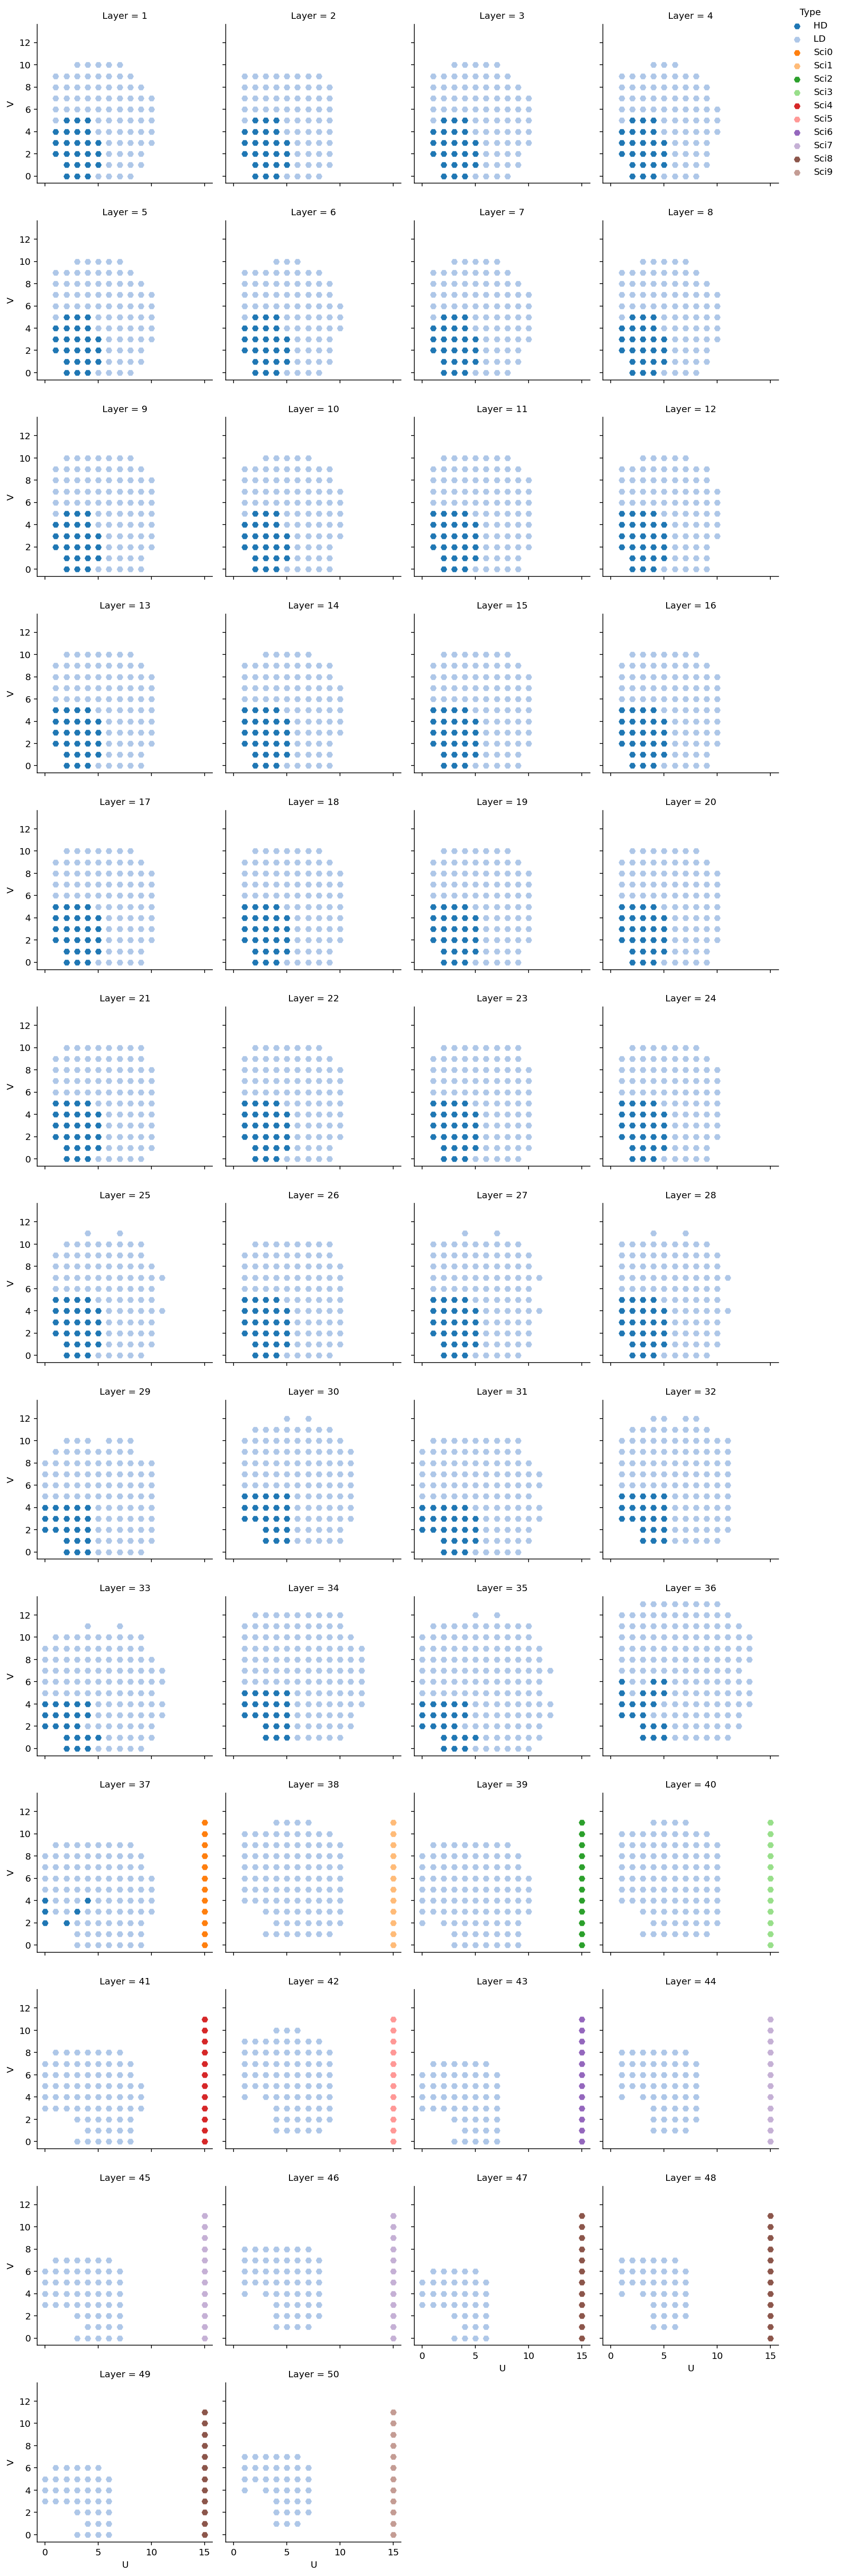

In [16]:
g = sns.FacetGrid(rates, hue='Type', col='Layer',
    palette='tab20',
    sharex=True, sharey=True, col_wrap=4)
g.map(plt.scatter, 'U', 'V', marker='H')
g.add_legend(loc='upper right')

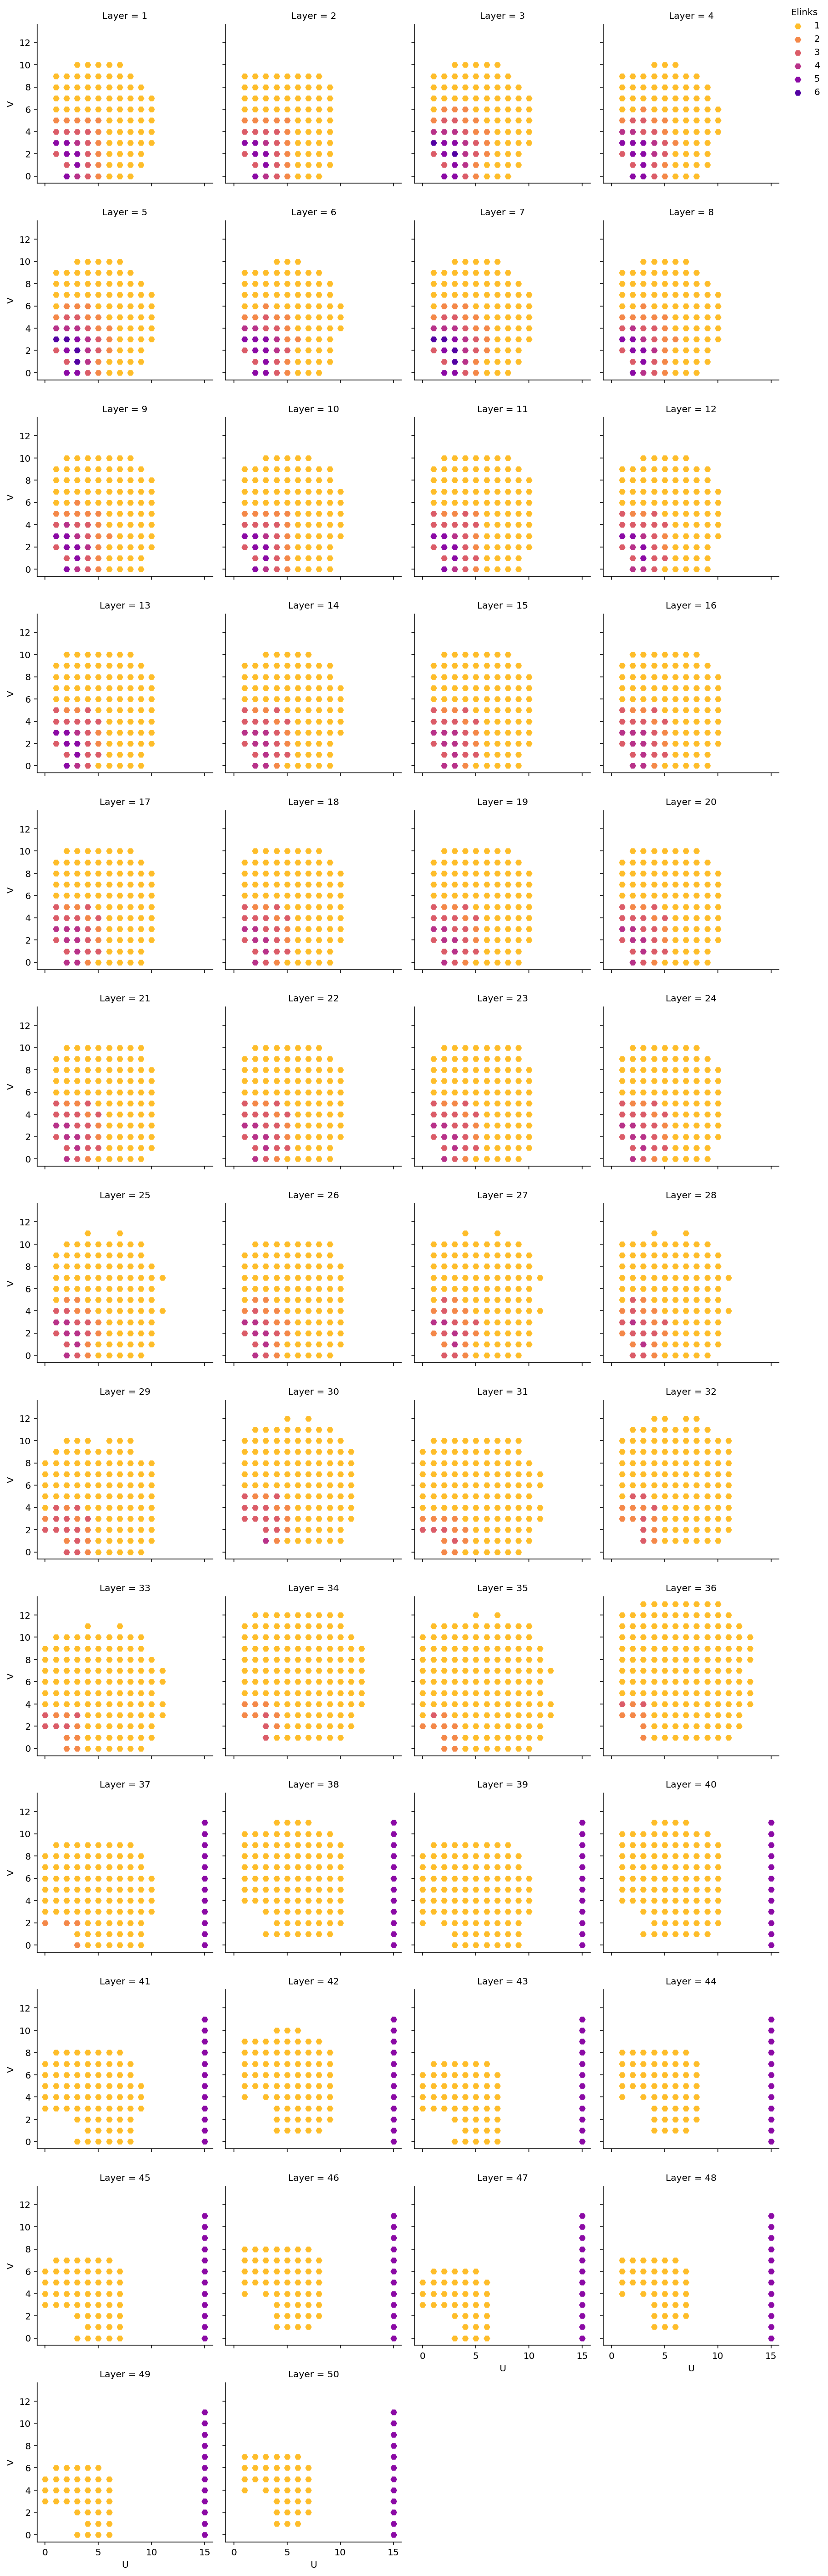

In [17]:
g = sns.FacetGrid(rates, hue='Elinks', col='Layer',
    palette='plasma_r',
    sharex=True, sharey=True, col_wrap=4)
g.map(plt.scatter, 'U', 'V', marker='H')
g.add_legend(loc='upper right')

## Read in Module->lpGBT mapping

Needs some labelling but also sanitizing the use of `-1`, since that can wreak havoc when performing aggregation.

In [18]:
with open('dat/maps/FeMappingV8.txt') as f:
    print(f.readline())

 1  2  1  0 d   1 1     0  3    -1 -1     0  6    -1 -1



In [19]:
links_col_description = {
    'Layer': 'Module Layer',
    'U': 'Module U',
    'V': 'Module V',
    'Type': 'Module type',
    'Shape': 'Module shape',
    'nDAQlpGBT': 'Number of DAQ lpGBTs used',
    'nTPGlpGBT': 'Number of TPG lpGBTs used',
    'DAQlpGBT1': '1st DAQ lpGBT',
    'nDAQlpGBT1Elinks': 'Number of Elinks to 1st DAQ lpGBT',
    'DAQlpGBT2': '2nd DAQ lpGBT',
    'nDAQlpGBT2Elinks': 'Number of Elinks to 2nd DAQ lpGBT',
    'TPGlpGBT1': '1st TPG lpGBT',
    'nTPGlpGBT1Elinks': 'Number of Elinks to 1st TPG lpGBT',
    'TPGlpGBT2': '2nd TPG lpGBT',
    'nTPGlpGBT2Elinks': 'Number of Elinks to 2nd TPG lpGBT',
}

#Extract the column labels for the data frame (freeze it in a tuple)
links_col_labels=tuple(links_col_description.keys())

#Make the main description dict reversible for easy .rename() of columns back and forth
links_col_description.update(
    {long: short for (short, long) in links_col_description.items()}
    )

pprint(links_col_labels)

('Layer',
 'U',
 'V',
 'Type',
 'Shape',
 'nDAQlpGBT',
 'nTPGlpGBT',
 'DAQlpGBT1',
 'nDAQlpGBT1Elinks',
 'DAQlpGBT2',
 'nDAQlpGBT2Elinks',
 'TPGlpGBT1',
 'nTPGlpGBT1Elinks',
 'TPGlpGBT2',
 'nTPGlpGBT2Elinks')


In [20]:
links = pd.read_table(
    'dat/maps/FeMappingV8.txt',
    sep='\s+',
    header=None,
    names=links_col_labels,
    converters={
        'Type': lambda x: module_type[int(x)],
        },
    dtype={
        'nDAQlpGBT': np.uint8,
        'nTPGlpGBT': np.uint8,
        'DAQlpGBT1': 'Int16',
        'nDAQlpGBT1Elinks': 'Int8',
        'DAQlpGBT2': 'Int16',
        'nDAQlpGBT2Elinks': 'Int8',
        'TPGlpGBT1': 'Int16',
        'nTPGlpGBT1Elinks': 'Int8',
        'TPGlpGBT2': 'Int16',
        'nTPGlpGBT2Elinks': 'Int8',
        'Layer': np.uint8,
        'U': np.int8,
        'V': np.int8,
        },
    )

links.replace(-1, pd.NA, inplace=True)

make_LUV_index(links)

links.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5066 entries, 289 to 12795
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Layer             5066 non-null   uint8 
 1   U                 5066 non-null   int8  
 2   V                 5066 non-null   int8  
 3   Type              5066 non-null   object
 4   Shape             5066 non-null   object
 5   nDAQlpGBT         5066 non-null   uint8 
 6   nTPGlpGBT         5066 non-null   uint8 
 7   DAQlpGBT1         4851 non-null   Int16 
 8   nDAQlpGBT1Elinks  4851 non-null   Int8  
 9   DAQlpGBT2         110 non-null    Int16 
 10  nDAQlpGBT2Elinks  110 non-null    Int8  
 11  TPGlpGBT1         3467 non-null   Int16 
 12  nTPGlpGBT1Elinks  3467 non-null   Int8  
 13  TPGlpGBT2         501 non-null    Int16 
 14  nTPGlpGBT2Elinks  501 non-null    Int8  
dtypes: Int16(4), Int8(4), int8(2), object(2), uint8(3)
memory usage: 742.4 KB


In [21]:
links

,Layer,U,V,Type,Shape,nDAQlpGBT,nTPGlpGBT,DAQlpGBT1,nDAQlpGBT1Elinks,DAQlpGBT2,nDAQlpGBT2Elinks,TPGlpGBT1,nTPGlpGBT1Elinks,TPGlpGBT2,nTPGlpGBT2Elinks
LUV,,,,,,,,,,,,,,,
289,1,2,1,HD,d,1,1,0,3,<NA>,<NA>,0,6,<NA>,<NA>
306,1,3,2,HD,F,2,2,0,4,1,1,0,1,1,6
323,1,4,3,HD,F,1,2,1,3,<NA>,<NA>,1,1,2,4
274,1,1,2,HD,d,1,1,2,3,<NA>,<NA>,3,6,<NA>,<NA>
275,1,1,3,HD,F,2,2,2,4,3,1,3,1,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12791,50,15,7,Sci9,f,1,1,1503,5,<NA>,<NA>,1582,7,<NA>,<NA>
12792,50,15,8,Sci9,F,1,1,1504,5,<NA>,<NA>,1583,7,<NA>,<NA>
12793,50,15,9,Sci9,F,1,1,1505,5,<NA>,<NA>,1584,7,<NA>,<NA>


In [22]:
links.describe(include='all')

,Layer,U,V,Type,Shape,nDAQlpGBT,nTPGlpGBT,DAQlpGBT1,nDAQlpGBT1Elinks,DAQlpGBT2,nDAQlpGBT2Elinks,TPGlpGBT1,nTPGlpGBT1Elinks,TPGlpGBT2,nTPGlpGBT2Elinks
count,5066.000000,5066.000000,5066.000000,5066,5066,5066.000000,5066.000000,4851.000000,4851.000000,110.000000,110.000000,3467.000000,3467.000000,501.000000,501.000000
unique,NaN,NaN,NaN,12,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,LD,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,4014,3791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,24.581919,5.805764,5.251086,NaN,NaN,0.979274,0.783261,738.635127,1.469800,324.018182,1.500000,820.667147,2.285838,645.892216,1.455090
std,13.372177,3.302064,3.092092,NaN,NaN,0.252460,0.606321,400.291829,1.049922,270.021269,0.713565,409.131749,1.401275,404.921548,1.077255
min,1.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,13.000000,3.000000,3.000000,NaN,NaN,1.000000,0.000000,396.000000,1.000000,131.500000,1.000000,496.000000,2.000000,299.000000,1.000000
50%,25.000000,6.000000,5.000000,NaN,NaN,1.000000,1.000000,769.000000,1.000000,258.000000,1.000000,848.000000,2.000000,625.000000,1.000000
75%,35.000000,8.000000,8.000000,NaN,NaN,1.000000,1.000000,1076.000000,1.000000,382.500000,2.000000,1157.500000,2.000000,981.000000,1.000000


In [57]:
g = sns.FacetGrid(links, hue='DAQlpGBT1', col='Layer',
    palette=it.cycle(sns.color_palette('bright')),
    sharex=True, sharey=True, col_wrap=4)
g.map(plt.scatter, 'U', 'V', marker='H')
g.add_legend(ncol=7, loc='upper right')

TypeError: boolean value of NA is ambiguous

## Merge the `rates` and `links` dataframes

The merge is automatically done on the `LUV` index.

In [24]:
modules = pd.merge(rates, links, how='outer')

In [25]:
modules['LUV'] = make_LUV(modules)

In [26]:
modules['doubleDAQlpGBT'] = (modules.nDAQlpGBT == 2)

In [27]:
modules.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5066 entries, 0 to 5065
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Layer             5066 non-null   uint64 
 1   U                 5066 non-null   int64  
 2   V                 5066 non-null   int64  
 3   Type              5066 non-null   object 
 4   Shape             5066 non-null   object 
 5   ADCHits           4851 non-null   float64
 6   TOXHits           4851 non-null   float64
 7   EvSize            4851 non-null   float64
 8   EvSizeXCheck      4851 non-null   float64
 9   Elinks            4851 non-null   float64
 10  nDAQlpGBT         5066 non-null   uint8  
 11  nTPGlpGBT         5066 non-null   uint8  
 12  DAQlpGBT1         4851 non-null   Int16  
 13  nDAQlpGBT1Elinks  4851 non-null   Int8   
 14  DAQlpGBT2         110 non-null    Int16  
 15  nDAQlpGBT2Elinks  110 non-null    Int8   
 16  TPGlpGBT1         3467 non-null   Int16  


In [28]:
modules

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks,...,DAQlpGBT1,nDAQlpGBT1Elinks,DAQlpGBT2,nDAQlpGBT2Elinks,TPGlpGBT1,nTPGlpGBT1Elinks,TPGlpGBT2,nTPGlpGBT2Elinks,LUV,doubleDAQlpGBT
0,1,3,2,HD,F,155.1390,13.47360,151.8780,148.0,5.0,...,0,4,1,1,0,1,1,6,306.0,True
1,1,2,1,HD,d,109.1950,13.96370,107.4950,108.0,3.0,...,0,3,<NA>,<NA>,0,6,<NA>,<NA>,289.0,False
2,1,4,3,HD,F,83.5257,5.64959,96.1745,93.0,3.0,...,1,3,<NA>,<NA>,1,1,2,4,323.0,False
3,1,1,3,HD,F,155.1070,13.53110,151.8990,149.0,5.0,...,2,4,3,1,3,1,4,6,275.0,True
4,1,1,2,HD,d,109.3270,13.89420,107.5330,108.0,3.0,...,2,3,<NA>,<NA>,3,6,<NA>,<NA>,274.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5061,49,7,2,LD,c,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,12658.0,False
5062,49,7,3,LD,c,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,12659.0,False
5063,50,3,8,LD,c,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,12856.0,False
5064,50,4,8,LD,c,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,12872.0,False


In [29]:
modules.describe(include = 'all')

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks,...,DAQlpGBT1,nDAQlpGBT1Elinks,DAQlpGBT2,nDAQlpGBT2Elinks,TPGlpGBT1,nTPGlpGBT1Elinks,TPGlpGBT2,nTPGlpGBT2Elinks,LUV,doubleDAQlpGBT
count,5066.000000,5066.000000,5066.000000,5066,5066,4851.000000,4851.000000,4851.000000,4851.000000,4851.000000,...,4851.000000,4851.000000,110.000000,110.000000,3467.000000,3467.000000,501.000000,501.000000,5066.000000,5066
unique,NaN,NaN,NaN,12,17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,LD,F,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,4014,3791,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4956
mean,24.581919,5.805764,5.251086,NaN,NaN,15.674103,2.212676,31.682696,31.643785,1.503814,...,738.635127,1.469800,324.018182,1.500000,820.667147,2.285838,645.892216,1.455090,6391.114489,NaN
std,13.372177,3.302064,3.092092,NaN,NaN,31.223396,5.005285,30.636124,30.686121,1.102077,...,400.291829,1.049922,270.021269,0.713565,409.131749,1.401275,404.921548,1.077255,3430.485879,NaN
min,1.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,9.000000,9.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,274.000000,NaN
25%,13.000000,3.000000,3.000000,NaN,NaN,0.676720,0.226915,15.766850,16.000000,1.000000,...,396.000000,1.000000,131.500000,1.000000,496.000000,2.000000,299.000000,1.000000,3460.250000,NaN
50%,25.000000,6.000000,5.000000,NaN,NaN,3.156350,0.605055,18.994100,19.000000,1.000000,...,769.000000,1.000000,258.000000,1.000000,848.000000,2.000000,625.000000,1.000000,6532.500000,NaN
75%,35.000000,8.000000,8.000000,NaN,NaN,14.143150,2.043410,32.316600,33.000000,1.000000,...,1076.000000,1.000000,382.500000,2.000000,1157.500000,2.000000,981.000000,1.000000,9157.750000,NaN


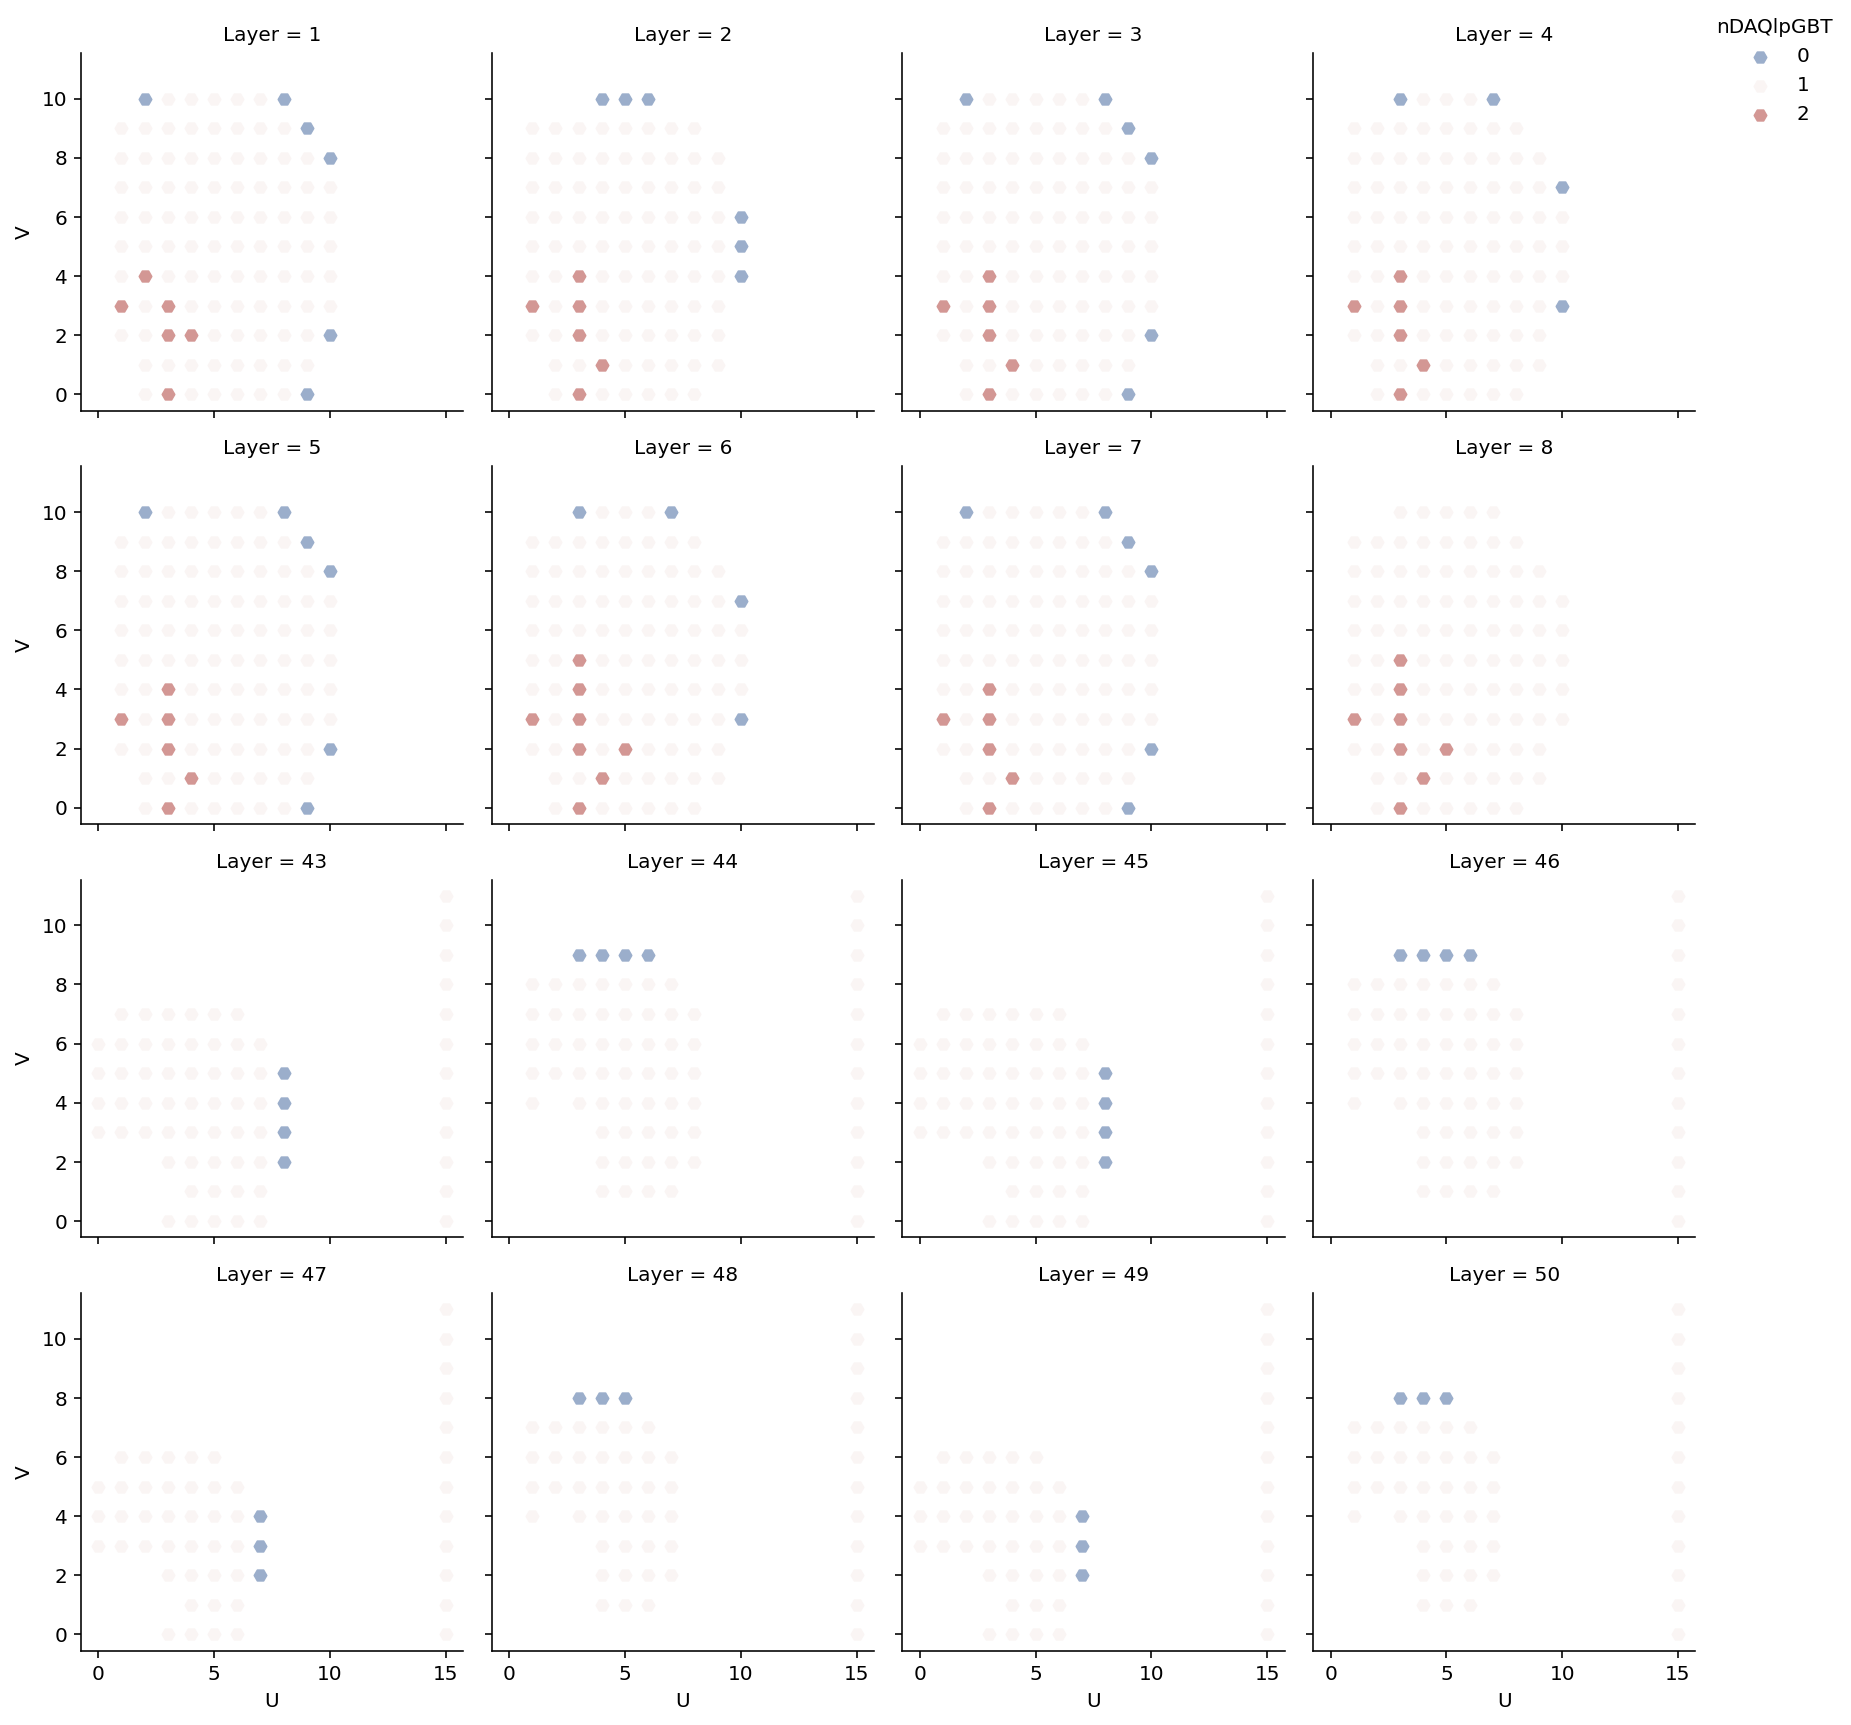

In [30]:
g = sns.FacetGrid(modules[ (modules.Layer<9) | (modules.Layer>42) ], col='Layer', hue='nDAQlpGBT',
    palette='vlag',
    sharex=True, sharey=True, col_wrap=4)
g.map(plt.scatter, 'U', 'V', marker='H')
g.add_legend(loc='upper right')

In [31]:
# Alas, this won't work with the 'Int16' types used above
# modules.to_hdf('out/merged.h5', 'modules', mode='w', format='table')

## Look for issues

### Outer partials

They do not have a lpGBT defined but their rates are taken into account as part of the full modules they are a part of.

In [32]:
modules['missing_lpGBT'] = (modules.nDAQlpGBT == 0)

In [33]:
modules[ modules.missing_lpGBT ][ ['Type','Shape'] ].describe(include='all')

,Type,Shape
count,215,215
unique,1,1
top,LD,c
freq,215,215


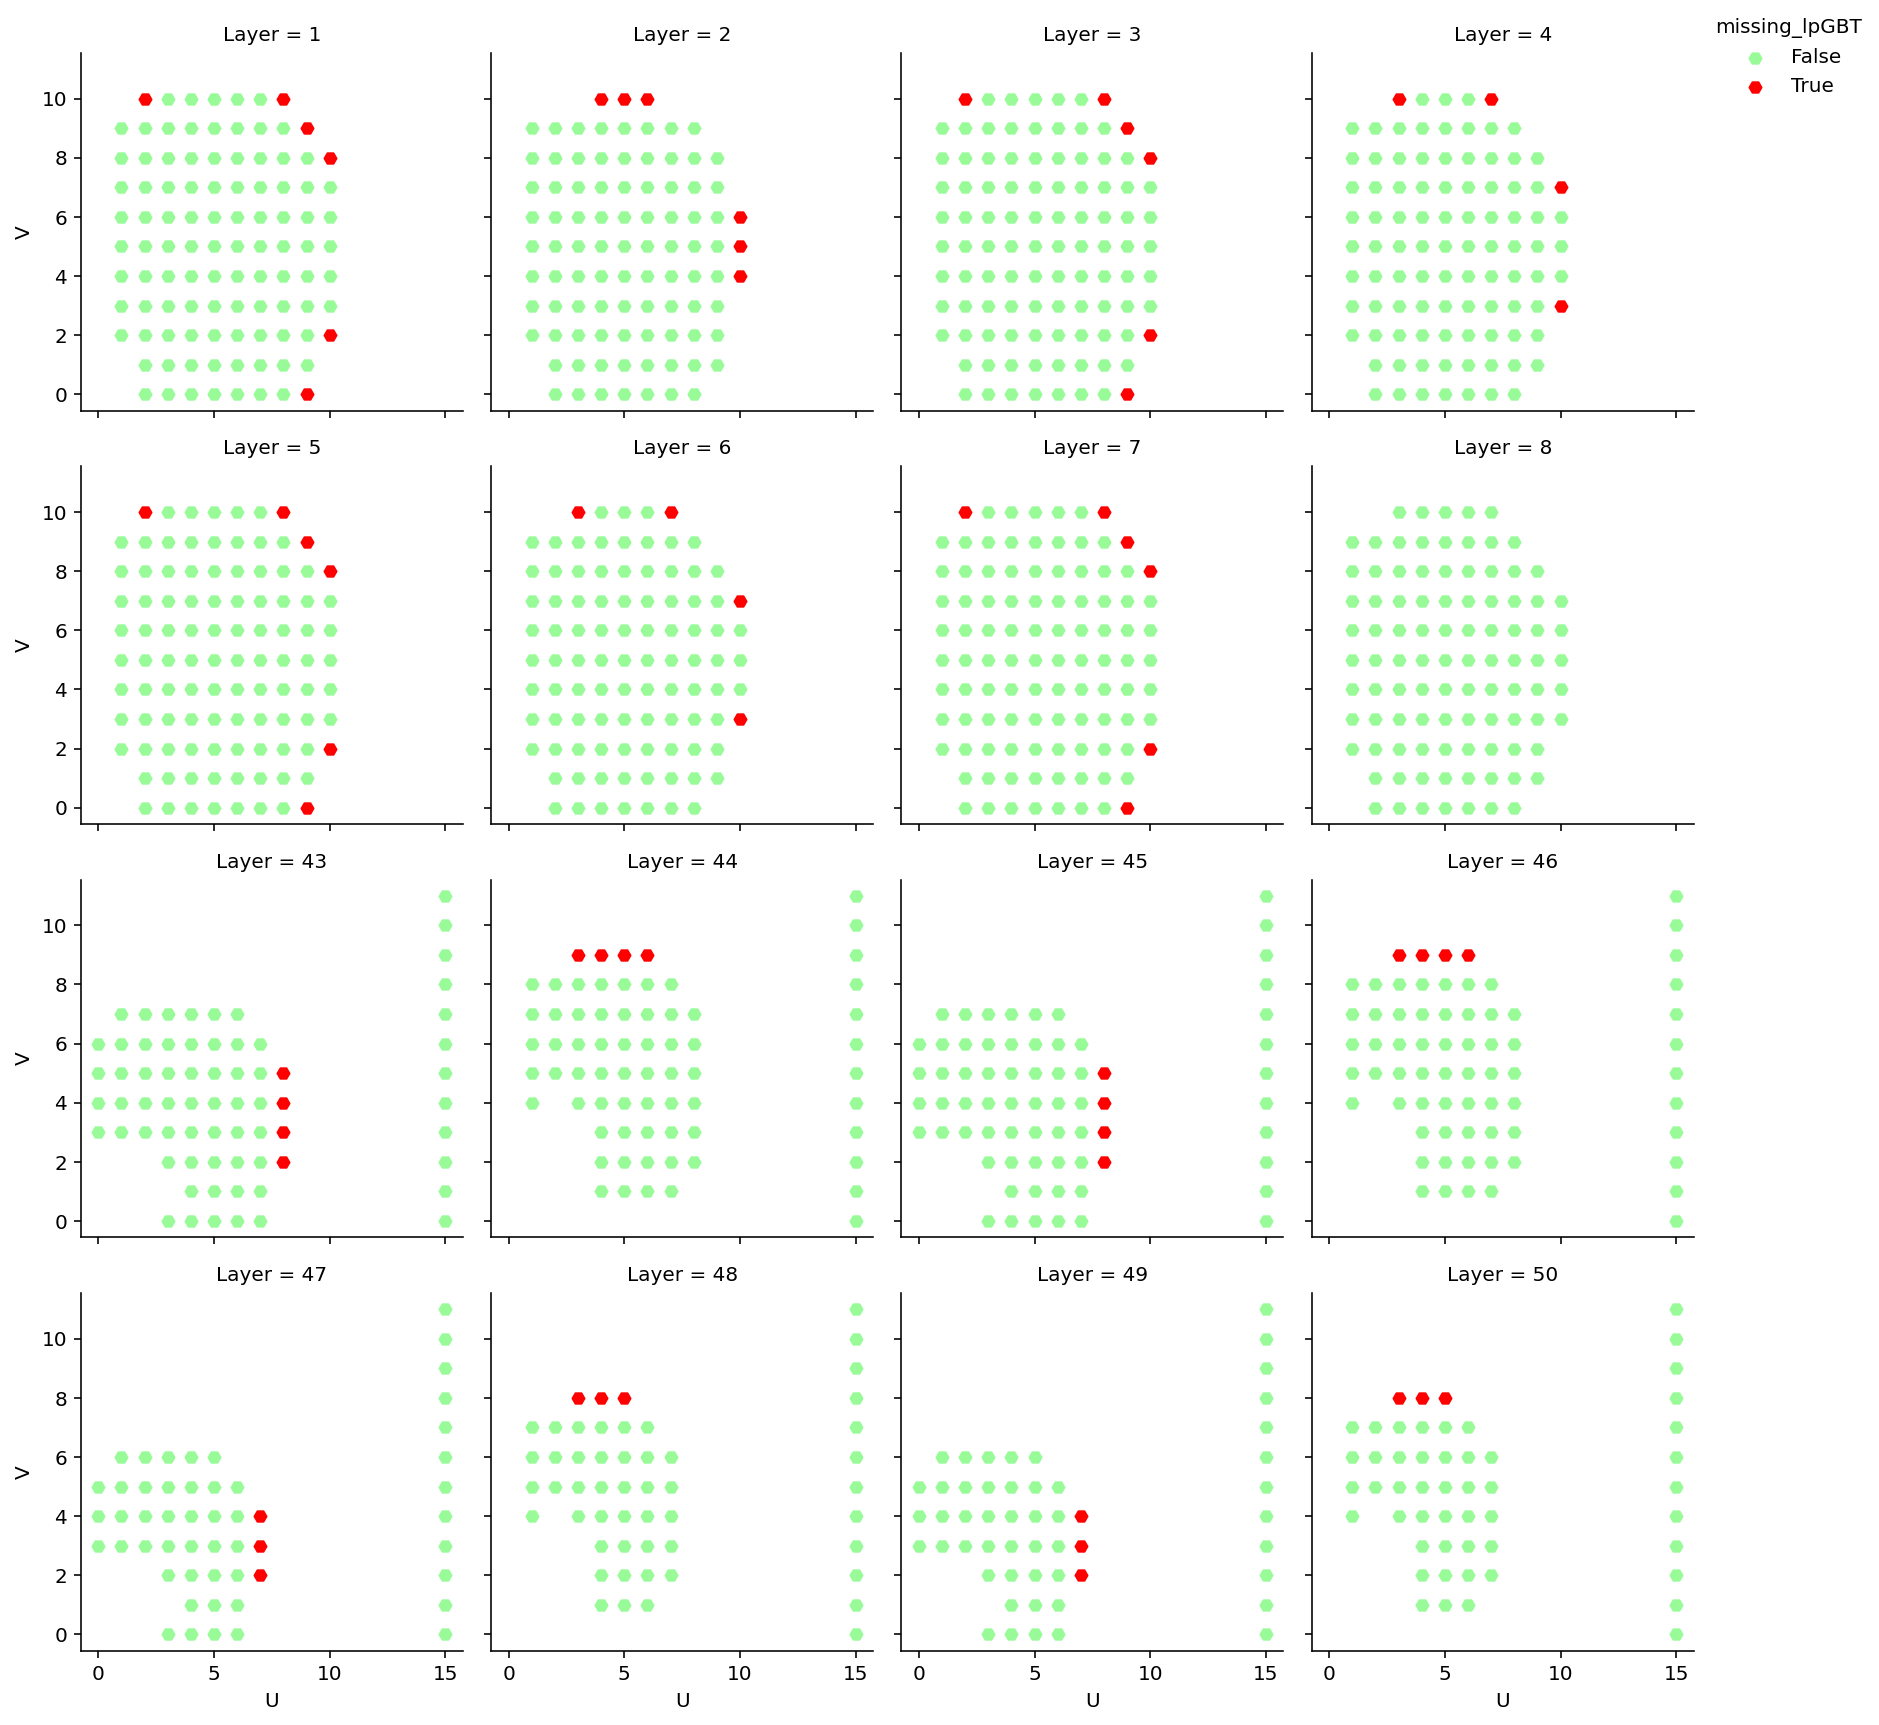

In [34]:
g = sns.FacetGrid(modules[ (modules.Layer<9) | (modules.Layer>42) ], col='Layer', hue='missing_lpGBT',
    sharex=True, sharey=True, col_wrap=4,
    palette=sns.color_palette(['palegreen','red']))
g.map(plt.scatter, 'U', 'V', marker='H')
g.add_legend(loc='upper right')

## How to split off the singles and the pairs?

Basically we have a layout of the form:

<table border="1">
<thead>
  <tr>
    <th>Module</th>
    <th>Link 1</th>
    <th>Link 2</th>
    <th>Rate sum</th>
    <th>Sum type</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>A</td>
    <td></td>
    <td rowspan="3">X</td>
    <td rowspan="3">Double</td>
  </tr>
  <tr>
    <td>2</td>
    <td>A</td>
    <td>B</td>
  </tr>
  <tr>
    <td>3</td>
    <td>B</td>
    <td></td>
  </tr>
  <tr>
    <td>4</td>
    <td>C</td>
    <td></td>
    <td>Y</td>
    <td>Single</td>
  </tr>
  <tr>
    <td>5</td>
    <td>D</td>
    <td></td>
    <td rowspan="2">Z</td>
    <td rowspan="2">Double</td>
  </tr>
  <tr>
    <td>6</td>
    <td>D</td>
    <td>E</td>
  </tr>
  <tr>
    <td>7</td>
    <td>F</td>
    <td></td>
    <td>W</td>
    <td>Single</td>
  </tr>
</tbody>
</table>

Note that `E` does not appear in the `Link1` column!

In [35]:
modules[ ['LUV', 'EvSize', 'DAQlpGBT1', 'DAQlpGBT2', 'doubleDAQlpGBT'] ].head(25)

,LUV,EvSize,DAQlpGBT1,DAQlpGBT2,doubleDAQlpGBT
0,306.0,151.8780,0,1,True
1,289.0,107.4950,0,<NA>,False
2,323.0,96.1745,1,<NA>,False
3,275.0,151.8990,2,3,True
4,274.0,107.5330,2,<NA>,False
5,276.0,96.0043,3,<NA>,False
6,304.0,125.3650,4,5,True
7,288.0,171.2950,4,<NA>,False
8,320.0,83.4939,5,<NA>,False
9,307.0,125.3770,6,7,True


Strategy to get rates for `singleDAQlpGBT`s and `doubleDAQlpGBT`s:
- find which are singles by removing guaranteed doubles from the list of all links.
- loop over doubles and find all modules with a link from the pair.

For each of these, aggregate the `EvSize` values and then concatenate the two aggregated tables (one for singles and one for doubles).

In [36]:
allDAQLinkIDs = np.concatenate([
    modules[ modules.DAQlpGBT1.notna() ].DAQlpGBT1,
    modules[ modules.DAQlpGBT2.notna() ].DAQlpGBT2
    ])

In [37]:
# Check that this is a list with no duplciates
assert( allDAQLinkIDs.max()+1 == len(set(allDAQLinkIDs)) )

In [38]:
allDAQLinkIDs = set(allDAQLinkIDs)

In [39]:
doubleDAQLinkIDs = np.concatenate([
    modules[ modules.doubleDAQlpGBT ].DAQlpGBT1,
    modules[ modules.doubleDAQlpGBT ].DAQlpGBT2
    ])

In [40]:
doubleDAQLinkIDs = set(doubleDAQLinkIDs)

In [41]:
singleDAQLinkIDs = allDAQLinkIDs.difference(doubleDAQLinkIDs)

In [42]:
singlelpGBTmodules = modules[ modules.DAQlpGBT1.isin(singleDAQLinkIDs) ]
sums = singlelpGBTmodules[
        ['EvSize', 'Elinks', 'DAQlpGBT1']
    ].groupby('DAQlpGBT1').sum()

means = singlelpGBTmodules[
        ['Layer', 'U', 'V', 'LUV', 'DAQlpGBT1']
    ].groupby('DAQlpGBT1').mean()

nmodules = singlelpGBTmodules[
        ['LUV', 'DAQlpGBT1']
    ].groupby('DAQlpGBT1').size()

singleRates = pd.merge( sums, means, on='DAQlpGBT1')
singleRates['nModules'] = nmodules
singleRates.reset_index(inplace=True)
singleRates.rename(columns={'DAQlpGBT1':'DAQlpGBT'}, inplace=True)
singleRates['doubleDAQlpGBT'] = False

In [43]:
singleRates.describe(include='all')

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT
count,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1288
mean,826.944099,90.460541,4.736025,27.039596,6.570872,5.095005,7032.365606,3.503882,NaN
std,415.564584,49.883023,1.224665,13.464073,4.082847,2.911791,3469.883103,1.530823,NaN
min,12.000000,12.189000,1.000000,1.000000,0.000000,0.000000,279.000000,1.000000,NaN
25%,505.750000,54.481525,4.000000,17.000000,3.625000,3.000000,4395.125000,2.750000,NaN
50%,839.500000,85.502150,5.000000,27.000000,6.000000,5.000000,7046.500000,4.000000,NaN
75%,1185.250000,115.528425,5.000000,38.000000,8.000000,7.500000,9971.250000,5.000000,NaN


In [44]:
# List of known doubles
doubles = modules[ modules.doubleDAQlpGBT ][ ['DAQlpGBT1', 'DAQlpGBT2'] ]

In [45]:
# Create the column and initialise it
modules['DAQlpGBTPair'] = pd.NA

# Loop over all double links in order then insert the information in the modules table
for double in doubles.itertuples(index=False):

    DAQlpGBTs = (double.DAQlpGBT1, double.DAQlpGBT2)

    # Select all modules that have either of the two DAQlpGBT IDs in either position
    modulesOfThisDouble = \
        reduce(op.or_,
            it.starmap(op.eq,
                it.product(
                        (modules.DAQlpGBT1, modules.DAQlpGBT2),
                        DAQlpGBTs,
                )
            )
        )

    # Assign the smallest ID of the two DAQlpGBTs in the pair to all concerned modules
    modules.loc[ modulesOfThisDouble, ['DAQlpGBTPair'] ] = min(DAQlpGBTs)


In [46]:
doublelpGBTmodules = modules[ ~modules.DAQlpGBTPair.isna() ]
sums = doublelpGBTmodules[
        ['EvSize', 'Elinks', 'DAQlpGBTPair']
    ].groupby('DAQlpGBTPair').sum()

means = doublelpGBTmodules[
        ['Layer', 'U', 'V', 'LUV', 'DAQlpGBTPair']
    ].groupby('DAQlpGBTPair').mean()

nmodules = doublelpGBTmodules[
        ['LUV', 'DAQlpGBTPair']
    ].groupby('DAQlpGBTPair').size()

doubleRates = pd.merge( sums, means, on='DAQlpGBTPair')
doubleRates['nModules'] = nmodules
doubleRates.reset_index(inplace=True)
doubleRates.rename(columns={'DAQlpGBTPair':'DAQlpGBT'}, inplace=True)
doubleRates['doubleDAQlpGBT'] = True

In [47]:
doubleRates.describe(include='all')

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
mean,323.018182,337.996220,10.863636,11.163636,2.878788,2.321212,2906.272727,3.072727,NaN
std,270.021269,89.178092,1.768622,8.618869,0.935458,1.441999,2206.337639,0.260877,NaN
min,0.000000,150.717900,8.000000,1.000000,1.000000,0.000000,275.000000,3.000000,NaN
25%,130.500000,278.736900,10.000000,5.000000,3.000000,1.000000,1331.250000,3.000000,NaN
50%,257.000000,355.528600,11.000000,9.000000,3.000000,3.000000,2353.000000,3.000000,NaN
75%,381.500000,405.062025,12.000000,13.000000,3.000000,3.000000,3384.875000,3.000000,NaN


In [48]:
linkRates = pd.concat(
    (singleRates, doubleRates)
    )

In [49]:
linkRates['EvSize [kb]'] = linkRates['EvSize'] * 32 * 1e-3 # bit/word * kbit/bit

In [50]:
linkRates.describe(include='all')

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb]
count,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398,1398.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1288,NaN
mean,787.293276,109.937597,5.218169,25.790415,6.280365,4.876753,6707.708798,3.469957,NaN,3.518003
std,428.026769,85.778683,2.085581,13.823449,4.051449,2.920843,3564.675649,1.475701,NaN,2.744918
min,0.000000,12.189000,1.000000,1.000000,0.000000,0.000000,275.000000,1.000000,NaN,0.390048
25%,436.500000,55.834265,4.000000,15.000000,3.000000,2.500000,3861.250000,3.000000,NaN,1.786696
50%,790.500000,90.116900,5.000000,26.000000,5.500000,4.666667,6710.000000,4.000000,NaN,2.883741
75%,1157.750000,134.574200,6.000000,38.000000,8.000000,7.500000,9764.500000,5.000000,NaN,4.306374


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='EvSize [kb]'>

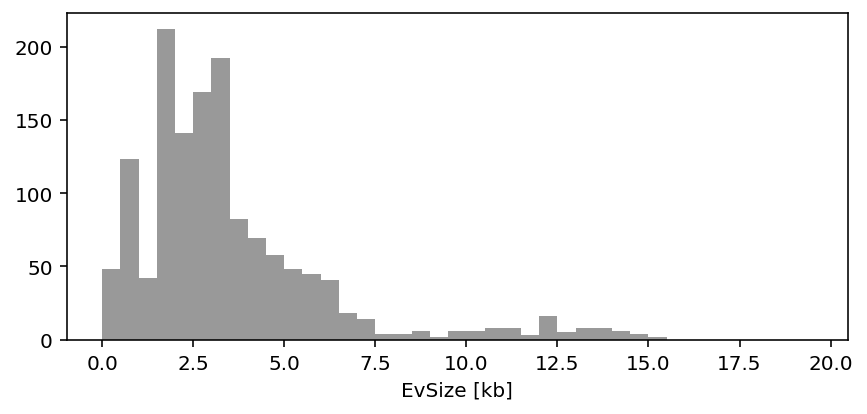

In [51]:
bins=np.arange(
    0,
    round(linkRates['EvSize [kb]'].max(), -1),
    0.5
    )

f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(linkRates['EvSize [kb]'], bins=bins, color='black', kde=False)

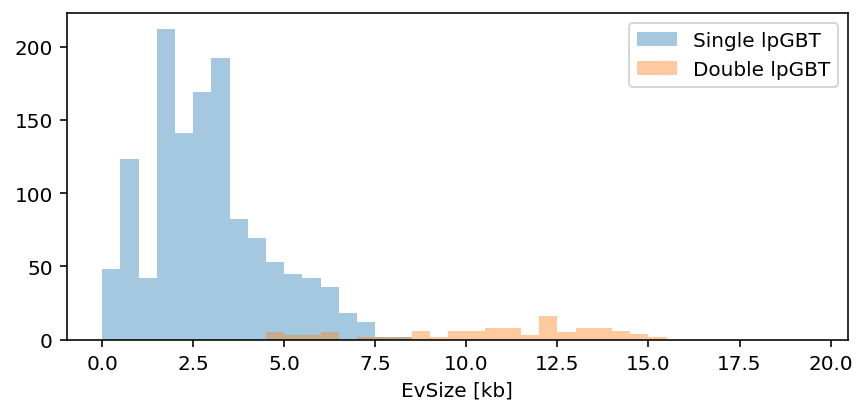

In [52]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(linkRates[~linkRates.doubleDAQlpGBT]['EvSize [kb]'], bins=bins, label='Single lpGBT', kde=False)
sns.distplot(linkRates[ linkRates.doubleDAQlpGBT]['EvSize [kb]'], bins=bins, label='Double lpGBT', kde=False)
plt.legend()

<AxesSubplot:xlabel='LUV', ylabel='EvSize [kb]'>

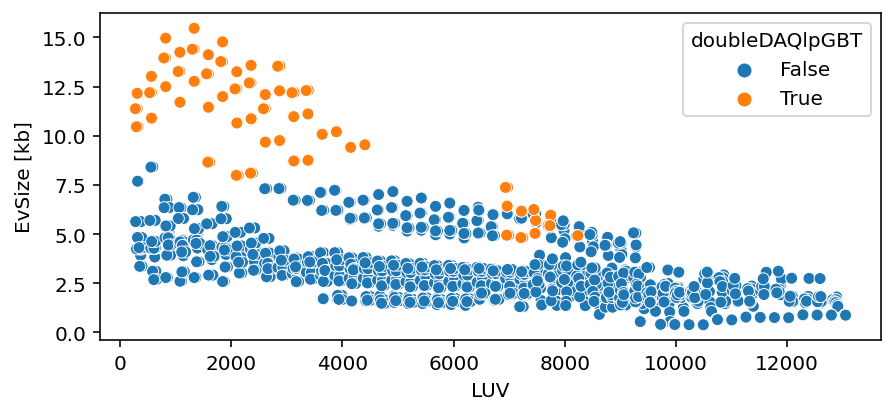

In [53]:
f, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x='LUV', y='EvSize [kb]', hue='doubleDAQlpGBT', data=linkRates)

<AxesSubplot:xlabel='LUV', ylabel='Elinks'>

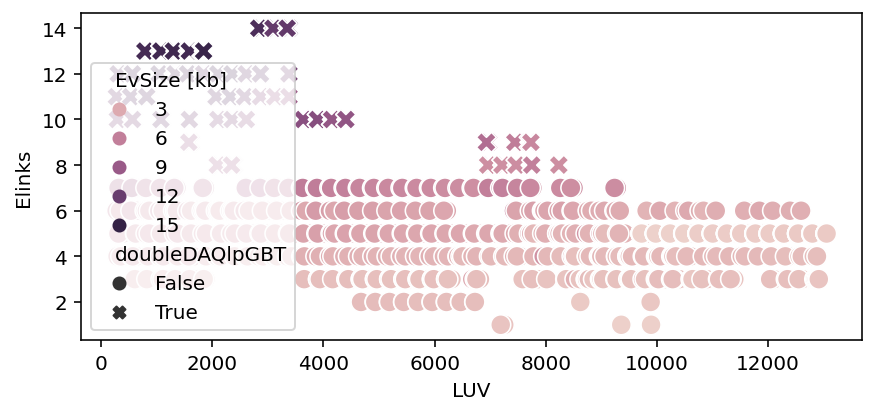

In [54]:
f, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x='LUV', y='Elinks', hue='EvSize [kb]', style='doubleDAQlpGBT', s=1e2, data=linkRates)

<AxesSubplot:xlabel='EvSize [kb]', ylabel='BitsPerElink'>

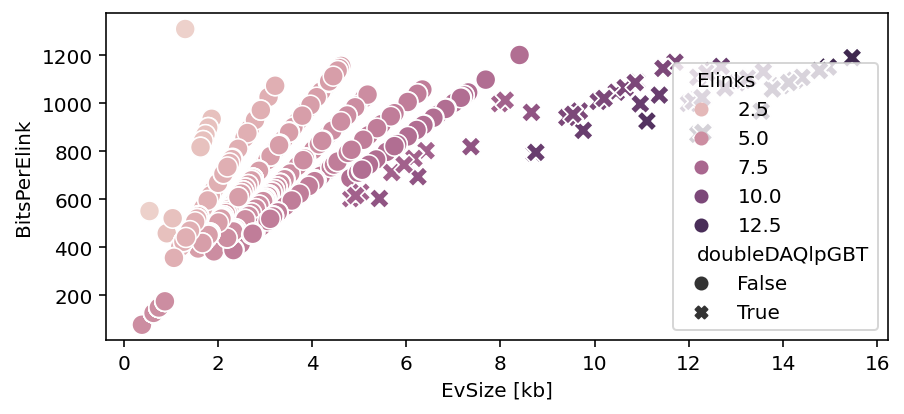

In [55]:
linkRates['BitsPerElink'] = linkRates['EvSize [kb]'] * 1e3 / linkRates['Elinks']
f, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x='EvSize [kb]', y='BitsPerElink', hue='Elinks', style='doubleDAQlpGBT', s=1e2, data=linkRates)

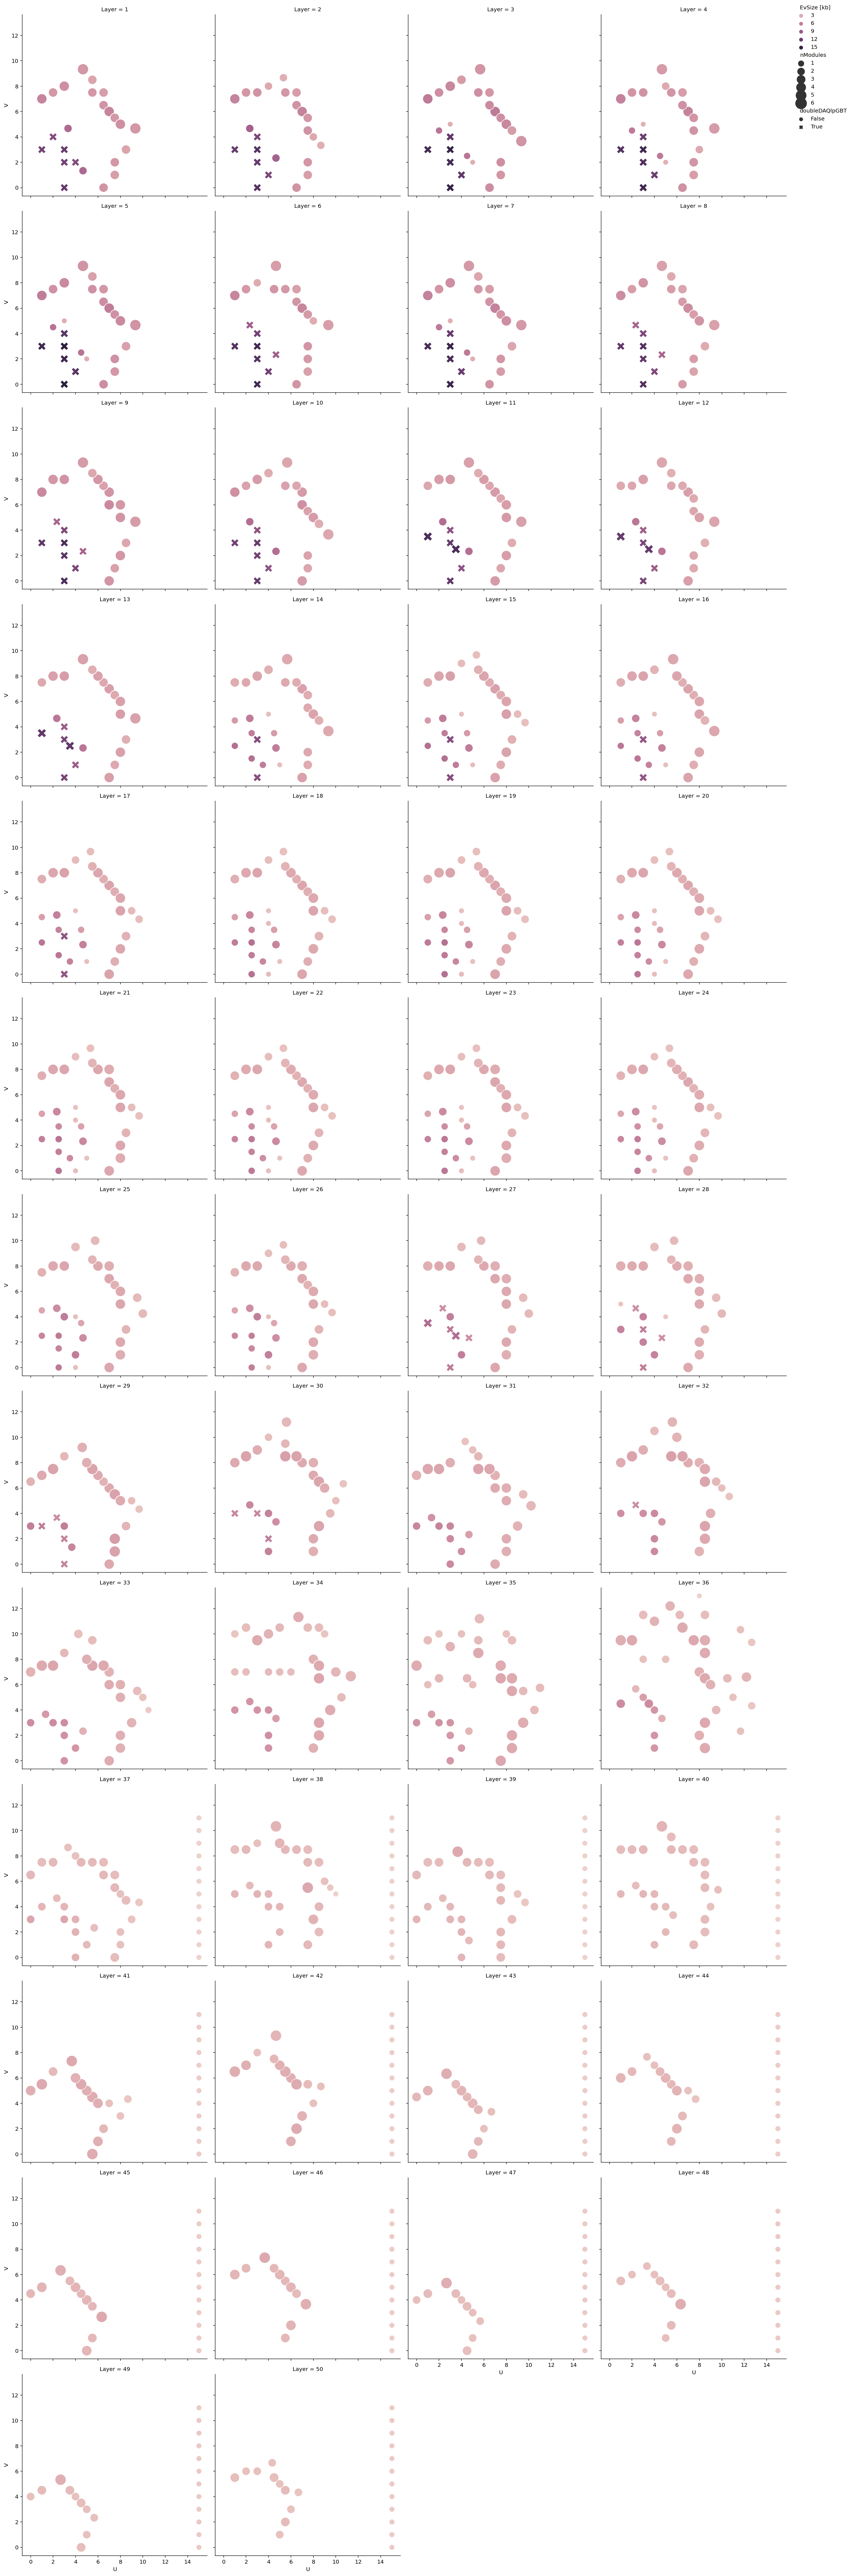

In [56]:
g = sns.relplot(data=linkRates,
    x='U', y='V', hue='EvSize [kb]', col='Layer', style='doubleDAQlpGBT', size='nModules',
    sizes=(100, 400), col_wrap=4,
    facet_kws={'sharex':True, 'sharey':True}
    )
g._legend._loc = 1

In [ ]:
linkRates.to_hdf('out/merged_V8.h5', 'linkRates', mode='a')

In [ ]:
linkRates.to_csv('linRates_V8.csv')